# Hidden Markov Model

In [13]:
from sklearn.mixture import GaussianMixture 
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import toolkit as kit
import warnings
import scipy
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import kstest
import matplotlib.dates as mdates
from scipy import integrate
from hmmlearn import hmm


%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = kit.get_ind_30_ret()

## Model Selection and Prepocessing

We use AIC and BIC to determine the optimal number of latent states for each asset.

In [24]:
food = kit.get_ind_30_ret()['Food']
food_arr = np.array(food)

In [25]:
aics = []
bics = []
ll = []

In [26]:
for i in range(3, 9):
    model = hmm.GaussianHMM(n_components=i, covariance_type='full', n_iter=1000, random_state=2023)
    model.fit(food_arr.reshape(-1, 1))
    aics.append(model.aic(food_arr.reshape(-1, 1)))
    bics.append(model.bic(food_arr.reshape(-1, 1)))
    ll.append(model.score(food_arr.reshape(-1, 1)))

In [27]:
num_states_scores = pd.DataFrame({'Number of Latent States': np.arange(3,9), 'LogLikelihood': ll, 'AIC': aics, 'BIC': bics})
num_states_scores = num_states_scores.set_index('Number of Latent States')
num_states_scores

,LogLikelihood,AIC,BIC
Number of Latent States,,,
3,2076.010014,-4124.020027,-4053.173358
4,2079.222523,-4112.445045,-3996.054089
5,2081.775191,-4095.550382,-3923.494185
6,2091.953905,-4089.907810,-3852.065421
7,2085.621682,-4047.243364,-3733.493829
8,2087.797811,-4017.595621,-3617.817988


In [28]:
num_states_scores.idxmin()

LogLikelihood    3
AIC              3
BIC              3
dtype: int64

We use BIC to determine the number of hidden states by selecting the minimum value of BIC.

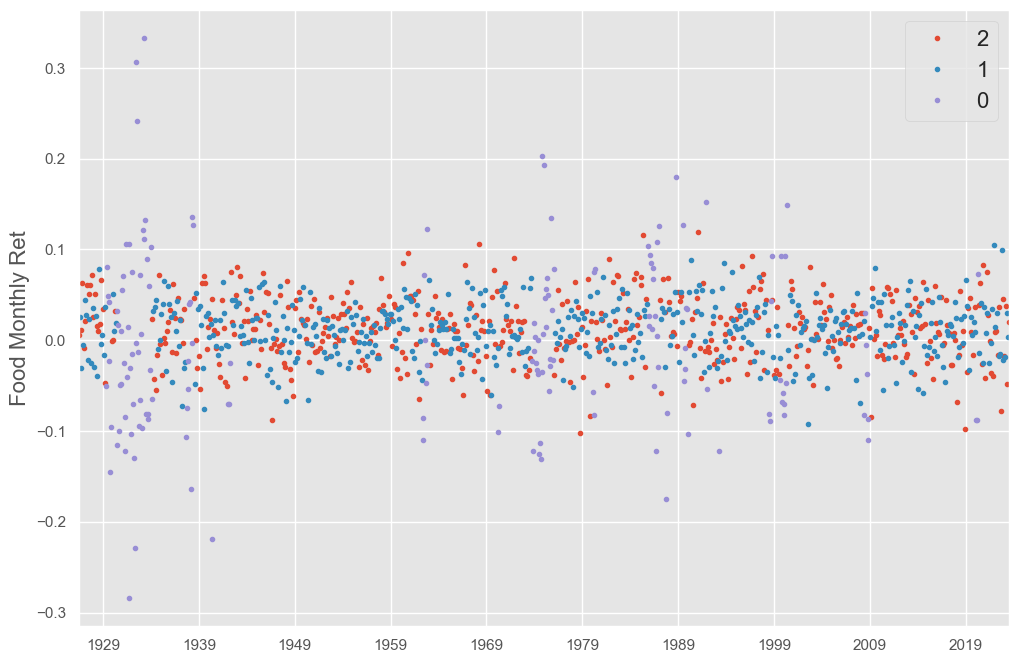

In [29]:
model = hmm.GaussianHMM(n_components=num_states_scores['BIC'].idxmin(), covariance_type='full', n_iter=1000, random_state=1)
model.fit(food_arr.reshape(-1, 1))
Z = model.predict(food_arr.reshape(-1, 1))
states = pd.unique(Z)
states
for i in states:
    index = (Z == i)
    x = food.iloc[index]
    x.plot(style='.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.ylabel("Food Monthly Ret", fontsize=16)
plt.show()

In [31]:
model.predict_proba(food_arr[-1].reshape(-1, 1))[0]

array([9.30003933e-55, 5.73899582e-25, 1.00000000e+00])

In [9]:
model.get_stationary_distribution()

array([0.16917541, 0.40674716, 0.42407743])

In [10]:
np.around(model.transmat_, 2)

array([[0.85, 0.02, 0.13],
       [0.06, 0.  , 0.94],
       [0.  , 0.95, 0.05]])

In [11]:
model.means_

array([[-0.00296309],
       [ 0.01085164],
       [ 0.01342482]])

In [12]:
model.covars_

array([[[0.00776867]],

       [[0.00087567]],

       [[0.00127108]]])

In [13]:
hidden_states = model.predict(food_arr.reshape(-1,1))
hidden_states

array([2, 1, 2, ..., 2, 1, 2])

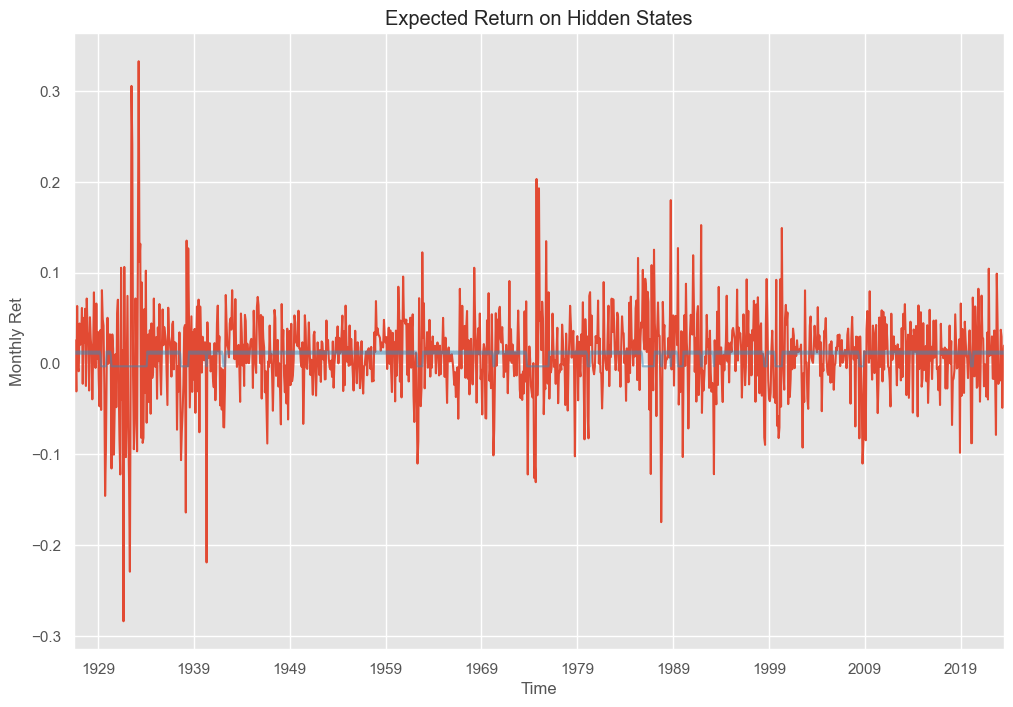

In [14]:
food.plot()
plt.plot(pd.Series(model.means_[hidden_states].reshape(-1), index=food.index), alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Monthly Ret')
plt.title('Expected Return on Hidden States');

Even the magnitudes vary significantly comparing the two line plots but we do recognize the expected return in the volatile state is negative and relatively positive for stable states.

In [15]:
df = pd.DataFrame({'Ret':food, 'State': hidden_states})
df['Positive?'] = (df['Ret'] > 0).replace({True: '> 0', False: '<= 0'})
df.head()

,Ret,State,Positive?
1926-07,0.0056,2,> 0
1926-08,0.0259,1,> 0
1926-09,0.0116,2,> 0
1926-10,-0.0306,1,<= 0
1926-11,0.0635,2,> 0


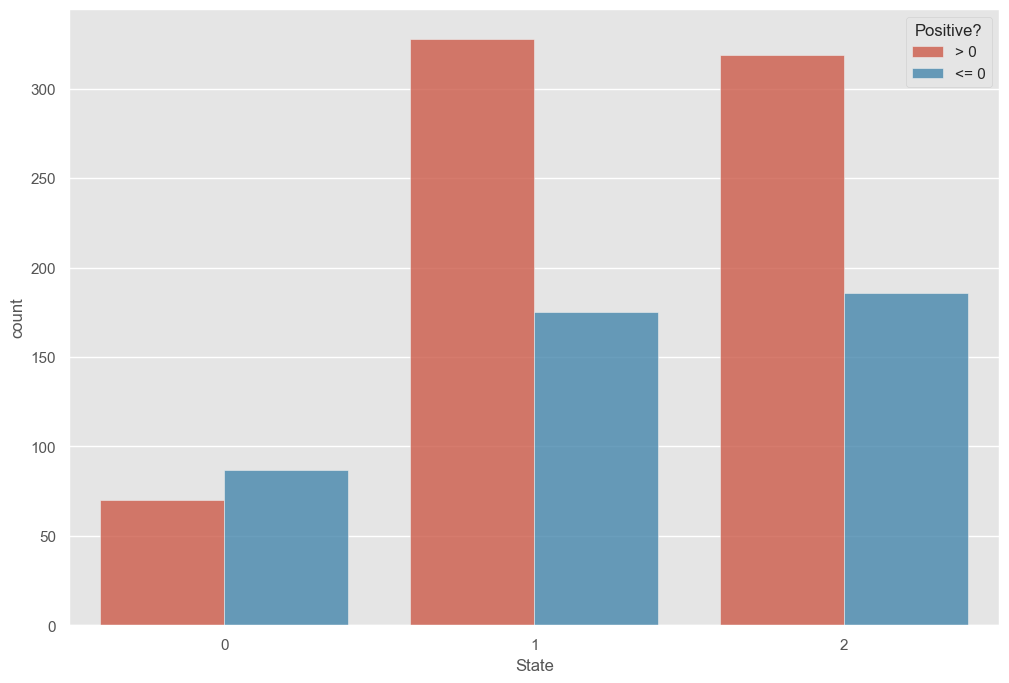

In [16]:
sns.countplot(df, x="State", hue='Positive?', alpha=0.8);

We observe State 0 has more non-positive returns and State 1 and 2 are characterized with more positive than negative returns.

In [17]:
np.around(model.transmat_, 2)

array([[0.85, 0.02, 0.13],
       [0.06, 0.  , 0.94],
       [0.  , 0.95, 0.05]])

In [18]:
## TODO: Interprete the transition matrix with the graph.

## Trading Strategy

We use 
$$
\mathbb{E}[O_{t+1}|Z_t]
$$
to estimate the expected return for the next month where $O_{t+1}$ is the next montly return given observed State $Z_t$ at current period. The weight of the expectation is given by the transition matrix. We also fit time series cross on all past to estimate model risk. 

### CV All Past

In [ ]:
num_states_scores['BIC'].idxmin()

In [216]:
t0 = int(len(food)*0.6)
fitted_ret = []
for t in range(t0+1,len(food_arr)):
    model = hmm.GaussianHMM(n_components=num_states_scores['BIC'].idxmin(), covariance_type='full', n_iter=1000, random_state=2023)
    train = food_arr[:t-1]
    model.fit(train.reshape(-1, 1))
    transition_matrix = model.transmat_
    hidden_states = model.predict(train.reshape(-1,1))
    Zt = hidden_states[-1]
    state_expected_ret = [np.mean(train[hidden_states==s]) for s in np.unique(hidden_states)]
    expected_ret = np.average(state_expected_ret, weights=transition_matrix[Zt])
    fitted_ret.append(expected_ret)

In [217]:
cv_all_past = pd.Series(fitted_ret, index = food.index[t0+1:])
cv_all_past.head()

1984-11    0.012112
1984-12    0.012119
1985-01    0.012093
1985-02    0.012101
1985-03    0.012093
Freq: M, dtype: float64

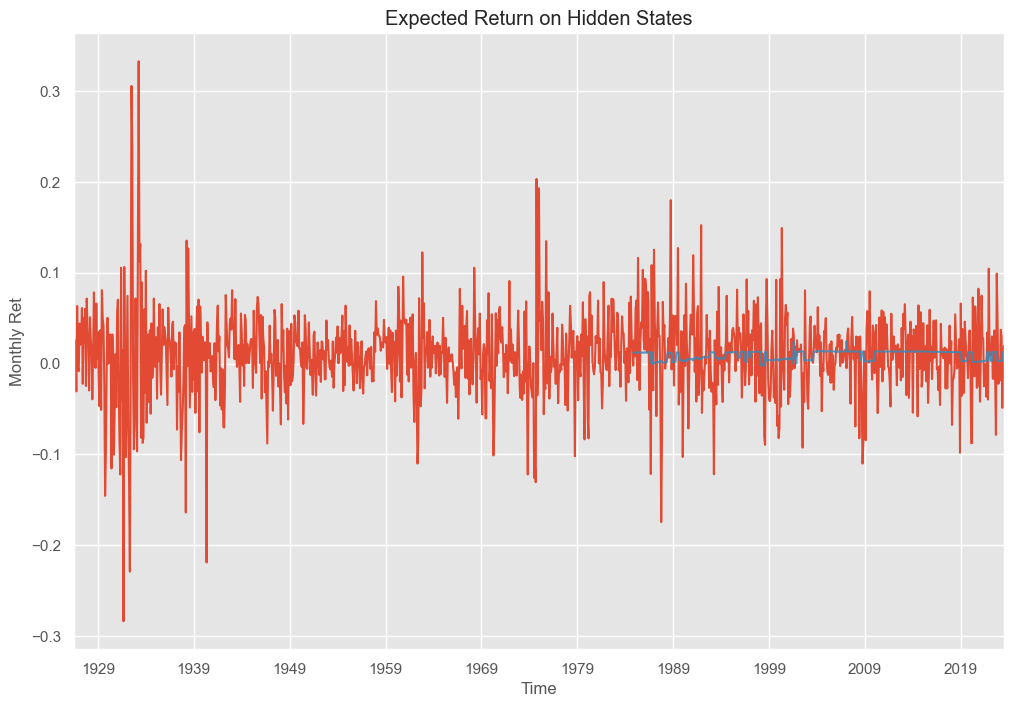

In [218]:
food.plot()
plt.plot(cv_all_past, alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Monthly Ret')
plt.title('Expected Return on Hidden States');

If the expected return is postive, we hold or buy the asset, else we sell the asset.

In [ ]:
sum(cv_all_past<0)

6

In [ ]:
sum(food[t0+1:]<0)

171

In [228]:
(food[t0+1:]+1).cumprod()

1984-11      0.997800
1984-12      1.023543
1985-01      1.031629
1985-02      1.094559
1985-03      1.170630
              ...    
2023-03     99.181676
2023-04    102.117454
2023-05     97.144334
2023-06     97.513482
2023-07     99.444249
Freq: M, Name: Food, Length: 465, dtype: float64

In [ ]:
(food[t0+1:][cv_all_past>=0]+1).cumprod()

1984-11      0.997800
1984-12      1.023543
1985-01      1.031629
1985-02      1.094559
1985-03      1.170630
              ...    
2023-03    104.892959
2023-04    107.997791
2023-05    102.738299
2023-06    103.128704
2023-07    105.170652
Freq: M, Name: Food, Length: 459, dtype: float64

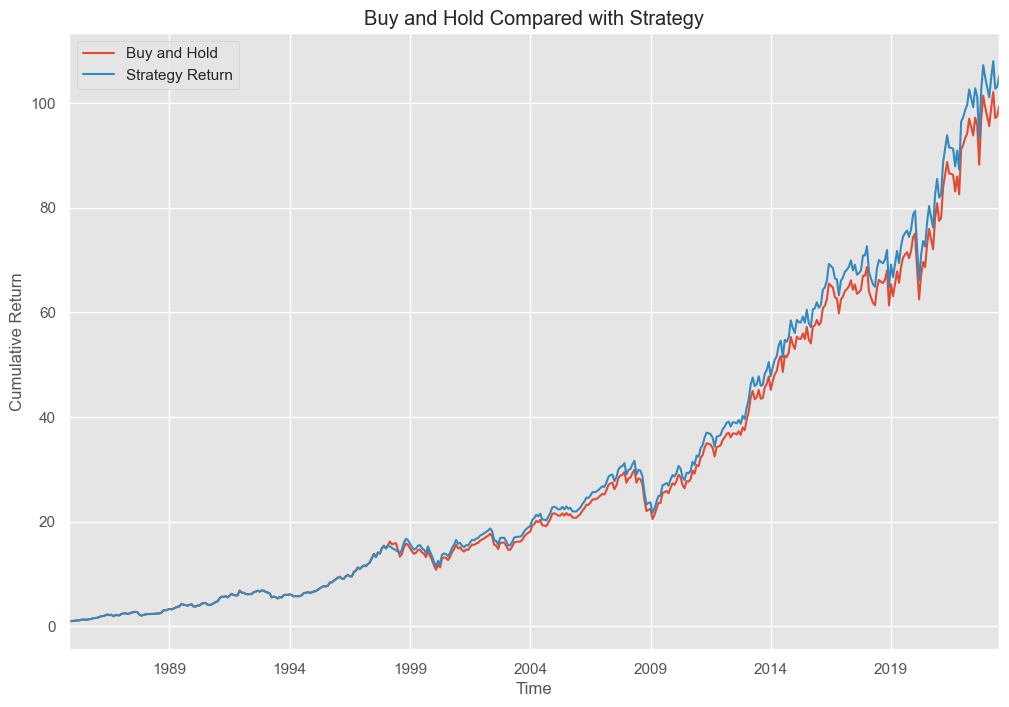

In [226]:
(food[t0+1:]+1).cumprod().plot('Buy and Hold')
(food[t0+1:][cv_all_past>=0]+1).cumprod().plot(label='Strategy Return')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.title('Buy and Hold Compared with Strategy');

## Construct Class

In [313]:
np.log(kit.get_ind_30_ret() + 1)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.005584,-0.053295,0.012818,0.028879,0.104090,-0.004812,0.077702,0.017545,0.078256,0.003892,...,0.008266,0.088194,0.020391,0.074179,0.018920,-0.271677,0.000700,0.018527,-0.000200,0.050693
1926-08,0.025570,0.239253,0.062975,0.005485,0.095401,-0.036457,-0.025420,0.041622,0.053541,0.076683,...,0.021468,0.019999,0.042964,-0.024088,0.047361,0.052498,-0.007528,-0.001301,0.043730,0.065413
1926-09,0.011533,0.039413,0.012521,0.063726,-0.009949,0.007273,-0.005113,0.006876,0.051928,0.022739,...,0.023814,0.022251,0.001898,-0.056994,0.000700,-0.081970,0.002497,-0.005616,-0.016231,-0.039365
1926-10,-0.031078,-0.033660,0.010544,-0.048770,0.090480,-0.047931,0.001199,-0.005716,-0.048770,0.009950,...,-0.001101,-0.020203,-0.010960,-0.052136,-0.026447,-0.167000,-0.022246,-0.041968,-0.056676,-0.088722
1926-11,0.061565,0.070365,0.044495,0.016464,-0.059750,-0.005415,0.018527,0.052782,0.050693,0.030529,...,0.016169,0.037007,0.035753,0.037681,0.015972,0.045642,0.063163,0.042389,0.023130,0.039221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,0.036621,0.040662,0.001099,0.024888,-0.039677,0.050313,0.041238,0.024595,-0.035938,-0.059432,...,-0.001301,0.093399,0.094037,0.001399,-0.008234,0.006081,0.036235,0.032854,-0.090581,0.021370
2023-04,0.029170,0.040950,0.040182,0.003394,0.015480,0.042676,0.021957,0.040374,-0.002904,0.040950,...,0.009851,0.020391,-0.018775,0.000800,-0.023883,0.004490,0.017545,0.049361,0.019508,0.042485
2023-05,-0.049926,-0.028914,-0.091348,0.021761,-0.006320,-0.095520,-0.145951,-0.037390,-0.079368,-0.120700,...,-0.098716,0.072228,0.079366,-0.082512,0.002597,-0.012781,0.020587,-0.052979,-0.038429,-0.023985
2023-06,0.003793,0.027518,0.074829,0.090846,0.058835,0.069526,0.068873,0.045547,0.105980,0.114845,...,0.045260,0.042772,0.077331,0.067565,0.110020,0.109751,0.076405,0.056002,0.057042,0.064945


In [32]:
def get_ind_49_daily_ret():
    """
    Load and format the Ken French Industry Portfolios files
    """    
    ind = pd.read_csv(f"../Data/ind49_d_vw_rets.csv", header=0, index_col=0, na_values=-99.99)/100
    ind.index = pd.to_datetime(ind.index.astype(str), format="%Y%m%d").to_period('D')
    ind.columns = ind.columns.str.strip()
    ind = np.log(ind + 1)
    ind = ind.interpolate(method='linear', limit_direction='both')
    return ind

In [33]:
data = get_ind_49_daily_ret()['1960':]

In [34]:
data

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1960-01-04,-0.004711,-0.001401,-0.001401,0.001199,-0.009949,0.015086,-0.005013,-0.006924,0.000200,0.004589,...,-0.008637,0.012719,0.004390,-0.001001,-0.007327,0.002397,-0.006521,0.003394,-0.001001,-0.002603
1960-01-05,0.009653,0.002397,-0.001401,0.006777,0.007373,0.047647,-0.000700,-0.005113,0.001699,0.006081,...,0.003195,0.015873,0.004390,0.001000,0.008167,-0.002704,0.011237,-0.008738,0.000500,0.013212
1960-01-06,-0.007428,-0.004309,-0.001401,-0.001401,0.003295,0.019508,-0.009646,-0.002503,0.002597,-0.003807,...,-0.003005,-0.010657,-0.003506,-0.002403,-0.007629,-0.000200,-0.017960,-0.015215,-0.010151,-0.008839
1960-01-07,-0.018368,-0.004711,-0.001401,0.002098,-0.002102,-0.000200,-0.003908,-0.006119,-0.006521,-0.006119,...,-0.010252,-0.006823,-0.009545,0.002098,-0.013187,-0.004410,-0.011162,-0.005616,-0.003908,0.005385
1960-01-08,-0.002804,-0.002303,-0.001401,0.005087,-0.006521,0.006479,-0.015926,0.015578,-0.007931,-0.000500,...,-0.013998,-0.005817,0.002696,0.000700,-0.005817,0.001099,0.002597,0.020391,-0.004108,0.009158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-0.002102,-0.006924,-0.007125,-0.004912,-0.010556,0.007174,0.003095,0.003892,-0.003606,-0.003908,...,0.004191,0.004988,0.007671,0.008464,-0.005314,0.003195,0.007373,-0.001501,0.001299,0.005087
2023-09-26,-0.007831,-0.000500,-0.008435,-0.011465,-0.010960,-0.015723,-0.009344,-0.012579,-0.011162,-0.008940,...,-0.016231,-0.017350,-0.014911,-0.023473,-0.007931,-0.015317,-0.012376,-0.017248,-0.018368,-0.009243
2023-09-27,-0.000500,-0.010758,-0.010353,-0.016536,-0.005415,0.000900,0.003095,0.005286,-0.011465,-0.004611,...,0.005584,0.001099,0.005883,0.000800,-0.005716,0.000100,-0.002303,0.001699,0.000200,-0.002603
2023-09-28,0.004092,-0.001201,-0.001101,0.000900,0.021370,0.014297,0.001399,0.013311,-0.000700,0.004988,...,0.009356,0.013804,0.006578,0.004092,0.012126,0.010148,0.005684,0.006578,0.010346,-0.001001


In [42]:
class IndustryHMM:
    def __init__(self, industry, name):
        ALL_DATA = kit.get_ind_30_ret()
        self.name = name
        self.data = ALL_DATA[industry]
        self.data_arr = np.array(self.data)
        self.num_states = 3
        self.initial_matrix = []
        self.transition_matrix = []
        self.means = []
        self.covariances = []
        self.hidden_states = []
        self.strategy1ret = []
        self.start_time = 0
        self.strategy1decisions = []
        self.confidence = []
        self.absolute_view = []

    def model_selection(self, print_table=False, message=False):
        aics = []
        bics = []
        ll = []
        for i in range(3, 6):
            model = hmm.GaussianHMM(n_components=i, covariance_type='full', n_iter=1000, random_state=2023)
            model.fit(self.data_arr.reshape(-1, 1))
            aics.append(model.aic(self.data_arr.reshape(-1, 1)))
            bics.append(model.bic(self.data_arr.reshape(-1, 1)))
            ll.append(model.score(self.data_arr.reshape(-1, 1)))
        num_states_scores = pd.DataFrame({'Number of Latent States': np.arange(3,6), 'Log Likelihood': ll, 'AIC': aics, 'BIC': bics})
        num_states_scores = num_states_scores.set_index('Number of Latent States')
        if print_table:
            display(num_states_scores)
        self.num_states = num_states_scores['BIC'].idxmin()
        if message:
            print(f'Best number of States selected by BIC is {self.num_states}')
    
    def industry_HMM_with_all_data(self, display_states=False):
        model = hmm.GaussianHMM(n_components=self.num_states, covariance_type='full', n_iter=1000, random_state=2023)
        model.fit(self.data_arr.reshape(-1, 1))
        Z = model.predict(self.data_arr.reshape(-1, 1))
        states = pd.unique(Z)
        
        if display_states:
            for i in states:
                index = (Z == i)
                x = self.data.iloc[index]
                x.plot(style='.')
            plt.legend(states, fontsize=16)
            plt.grid(True)
            plt.ylabel(f"{self.name} Monthly Return", fontsize=16)
            plt.show()
        
        self.initial_matrix = model.get_stationary_distribution()
        self.transition_matrix = np.around(model.transmat_, 2)
        self.means = model.means_
        self.covariances = model.covars_
        self.hidden_states = model.predict(self.data_arr.reshape(-1,1))
        
    
    def display_hidden_states_mean_return(self):
        self.data.plot()
        plt.plot(pd.Series(self.means[self.hidden_states].reshape(-1), index=self.data.index), alpha=0.5)
        plt.xlabel('Time')
        plt.ylabel('Monthly Return')
        plt.title('Expected Return on Hidden States');
    
    def display_countplot_positive_negative_hidden_states(self):
        df = pd.DataFrame({'Ret':self.data, 'State': self.hidden_states})
        df['Positive?'] = (df['Ret'] > 0).replace({True: '> 0', False: '<= 0'})
        sns.countplot(df, x="State", hue='Positive?', alpha=0.8)
        plt.title('Positive and Negative Returns in Hidden States');
        
        
    def trailing_CV(self, train_size=0.6, trailing_window=120, omega=0.6, mu=0.6, plot=False, decision_metrics='simple'):
        """
        hyperparameters to be tuned: train_size, trailing_window, omega, mu
        omega, mu can represent investor's risk averseness, higher values imply more risk averse.
        """
        n = len(self.data_arr)
        t0 = int(n*train_size)
        self.start_time = t0
        
        strategy1decisions = []
        confidence = []
        absolute_view = []
        
        for t in range(t0+1, n):
            # Fit HMM Model
            model = hmm.GaussianHMM(n_components=self.num_states, covariance_type='diag', n_iter=1000, random_state=2023)
            start = t-trailing_window-1
            train = self.data_arr[start:t]
            model.fit(train.reshape(-1, 1))
            
            #  Extract Parameter
            transition_matrix = model.transmat_
            hidden_states = model.predict(train.reshape(-1,1))
            Z_curr = hidden_states[-1]
            prob_Z_curr = model.predict_proba(train[-1].reshape(-1,1))[0][Z_curr]
            confidence.append(prob_Z_curr)
            
            # Find observations with the same state as O_t-1 in [t-W-1: t-2]
            obs_same_state = train[hidden_states==Z_curr][:-1]
            long_win_rate = np.sum(obs_same_state > 0) / len(obs_same_state)
            short_selling_rate = np.sum(obs_same_state < 0) / len(obs_same_state)
            
            true_indices = np.where(hidden_states==Z_curr)[0]
            next_growth_indices = true_indices + 1
            # Filter out indices that are out of bounds
            next_growth_indices = next_growth_indices[next_growth_indices < len(hidden_states)]
            next_growth = train[next_growth_indices]
            
            # similar to simple voting
            average_growth = np.mean(next_growth)
            # TODO:Try weighted voting by transition matrix 
            if decision_metrics == 'weighted':
                next_hidden_states = hidden_states[next_growth_indices]
                weight = transition_matrix[Z_curr][next_hidden_states]
                average_growth = np.average(next_growth, weights=weight)
            
            
            absolute_view.append(np.exp(np.mean(next_growth))-1)
                
            if average_growth > 0 and long_win_rate > omega:
                strategy1decisions.append(1)
            elif average_growth < 0 and short_selling_rate > mu:
                strategy1decisions.append(-1)
            else:
                strategy1decisions.append(0)
            
        strategy1decisions = pd.Series(strategy1decisions, index = self.data.index[t0+1:])
        self.strategy1decisions = strategy1decisions
        self.confidence = confidence
        self.absolute_view = absolute_view
        if plot:
            self.plot_decision_on_cum_return(strategy1decisions.index, strategy1decisions)
    
    def trading_strategy_ret(self, plot=False):
        """
        If the trading signal for y_t+1 = 1, buy portfolio.
        If the trading signal for y_t+1 = -1, sell portfolio.
        Else, stay still
        """
        adjusted_returns = []
        previous_signal = 0

        for signal, monthly_return in zip(self.strategy1decisions, self.data_arr[self.start_time+1:]):
            if signal == 1:
                adjusted_returns.append(monthly_return)
                previous_signal = 1
            elif signal == -1:
                adjusted_returns.append(-1* monthly_return)
                previous_signal = -1
            elif signal == 0:
                adjusted_returns.append(monthly_return)
                # Assuming lack of signal means volatile state -> 
                # we buy at the time since negative state may follow a positive one
        
        
        buy_hold = (self.data[self.start_time+1:]).cumsum()
        strategy_hmm = pd.Series(adjusted_returns, index = self.data.index[self.start_time+1:])
        strategy_hmm_cumprod = strategy_hmm.cumsum()
        print(len(strategy_hmm_cumprod))
        print(len(buy_hold))
        if plot:
            buy_hold.plot(label='Buy and Hold')
            strategy_hmm_cumprod.plot(label='Strategy HMM Return')
            plt.xlabel('Time')
            plt.ylabel('Cumulative Return')
            plt.legend()
            plt.title(f'Buy and Hold Compared with Trading Strategy');
            
        print(f'Buy and Hold: {buy_hold[-1]}\n Strategy HMM: {strategy_hmm_cumprod[-1]}')
        
        
    def all_past_CV(self, train_size=0.6, omega=0.6, mu=0.6, plot=False, decision_metrics='simple'):
        """
        hyperparameters to be tuned: train_size, omega, mu
        omega, mu can represent investor's risk averseness, higher values imply more risk averse.
        """
        n = len(self.data_arr)
        t0 = int(n*train_size)
        self.start_time = t0
        
        strategy1decisions = []
        confidence = []
        absolute_view = []
        
        for t in range(t0+1, n):
            # Fit HMM Model
            model = hmm.GaussianHMM(n_components=self.num_states, covariance_type='diag', n_iter=1000, random_state=2023)
            train = self.data_arr[:t]
            model.fit(train.reshape(-1, 1))
            
            #  Extract Parameter
            transition_matrix = model.transmat_
            hidden_states = model.predict(train.reshape(-1,1))
            Z_curr = hidden_states[-1]
            prob_Z_curr = model.predict_proba(train[-1].reshape(-1,1))[0][Z_curr]
            confidence.append(prob_Z_curr)
            
            # Find observations with the same state as O_t-1 in [0: t-2]
            obs_same_state = train[hidden_states==Z_curr][:-1]
            long_win_rate = np.sum(obs_same_state > 0) / len(obs_same_state)
            short_selling_rate = np.sum(obs_same_state < 0) / len(obs_same_state)
            
            true_indices = np.where(hidden_states==Z_curr)[0]
            next_growth_indices = true_indices + 1
            # Filter out indices that are out of bounds
            next_growth_indices = next_growth_indices[next_growth_indices < len(hidden_states)]
            next_growth = train[next_growth_indices]
            
            # similar to simple voting
            average_growth = np.mean(next_growth)
            # TODO:Try weighted voting by transition matrix 
            if decision_metrics == 'weighted':
                next_hidden_states = hidden_states[next_growth_indices]
                weight = transition_matrix[Z_curr][next_hidden_states]
                average_growth = np.average(next_growth, weights=weight)
            
            
            absolute_view.append(np.exp(np.mean(next_growth))-1)
                
            if average_growth > 0 and long_win_rate > omega:
                strategy1decisions.append(1)
            elif average_growth < 0 and short_selling_rate > mu:
                strategy1decisions.append(-1)
            else:
                strategy1decisions.append(0)
            
        strategy1decisions = pd.Series(strategy1decisions, index = self.data.index[t0+1:])
        self.strategy1decisions = strategy1decisions
        self.confidence = confidence
        self.absolute_view = absolute_view
        if plot:
            self.plot_decision_on_cum_return(strategy1decisions.index, strategy1decisions)
        
        
        
        
    def get_decison_array(self):
        return self.strategy1decisions
    
    def get_initial_matrix(self):
        return self.initial_matrix
    
    def get_transition_matrix(self):
        return self.transition_matrix
    
    def get_means(self):
        return self.means
    
    def get_covariances(self):
        return self.covariances
    
    def get_hidden_states(self):
        return self.hidden_states
    
    def get_confidence_array(self):
        return self.confidence
    
    def get_absolute_view(self):
        return self.absolute_view
    
    def get_CV_train_data(self):
        return self.data[self.start_time+1:]
    
    def get_CV_index(self):
        return self.data[self.start_time+1:].index
    
    def plot_decision_on_cum_return(self, time, arr):

        # Create patches for the legend
        patches = [
            plt.Rectangle((0,0),1,1,fc="green", alpha=0.3),
            plt.Rectangle((0,0),1,1,fc="red", alpha=0.3),
            plt.Rectangle((0,0),1,1,fc="white", alpha=0.3)
        ]
        self.data[self.start_time+1:].plot()
        for i in range(len(arr)-1):
            if arr[i] == 1:
                plt.axvspan(time[i].to_timestamp(), time[i+1].to_timestamp(), color='green', alpha=0.3)
            elif arr[i] == -1:
                plt.axvspan(time[i].to_timestamp(), time[i+1].to_timestamp(), color='red', alpha=0.3)

        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Highlight Regions Based on Decision')
        plt.legend(patches, ['Buy', 'Sell', 'Stay Still'], loc='best')

In [43]:
hmm_model = IndustryHMM('Food', 'Food Industry')

In [44]:
hmm_model.model_selection(print_table=True)

,Log Likelihood,AIC,BIC
Number of Latent States,,,
3,2083.408890,-4138.817780,-4067.971111
4,2092.927679,-4139.855358,-4023.464401
5,2098.578234,-4129.156468,-3957.100272


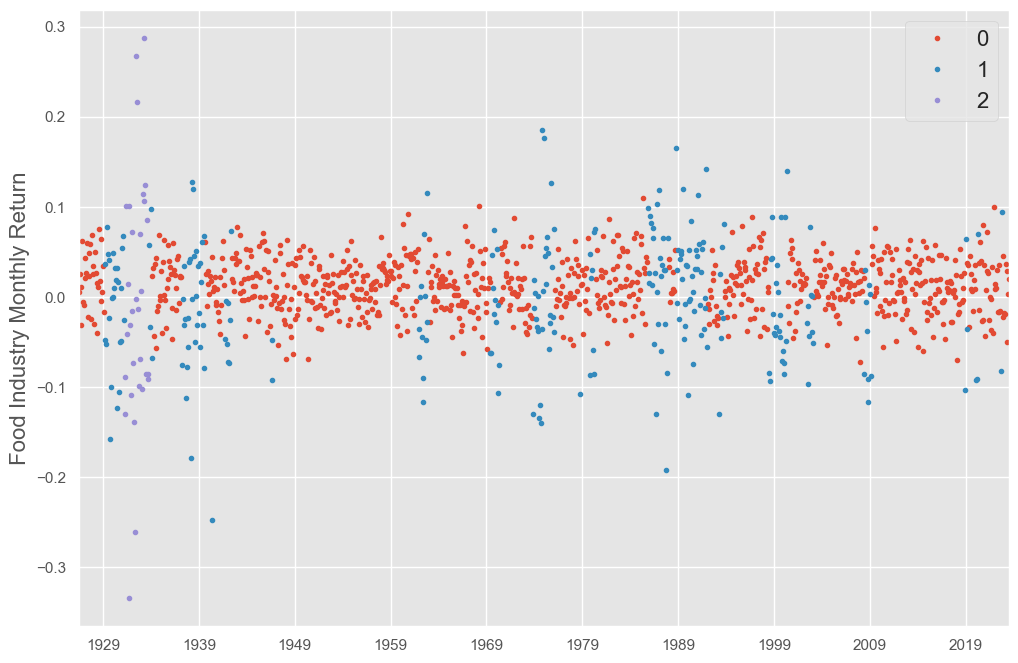

In [23]:
hmm_model.industry_HMM_with_all_data(display_states=True)

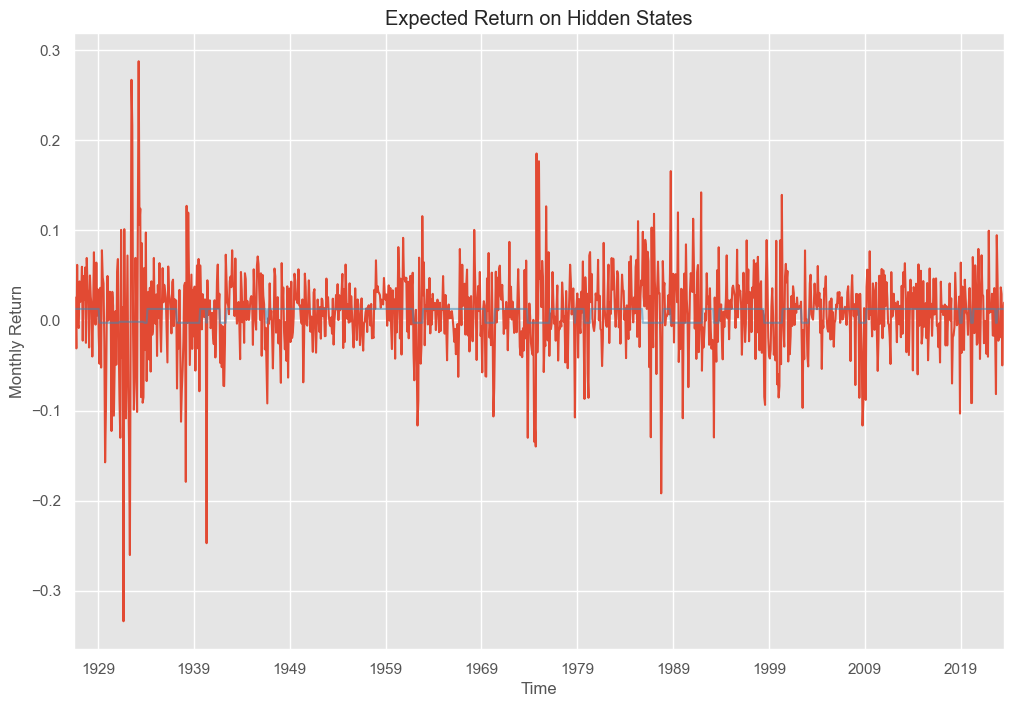

In [9]:
hmm_model.display_hidden_states_mean_return()

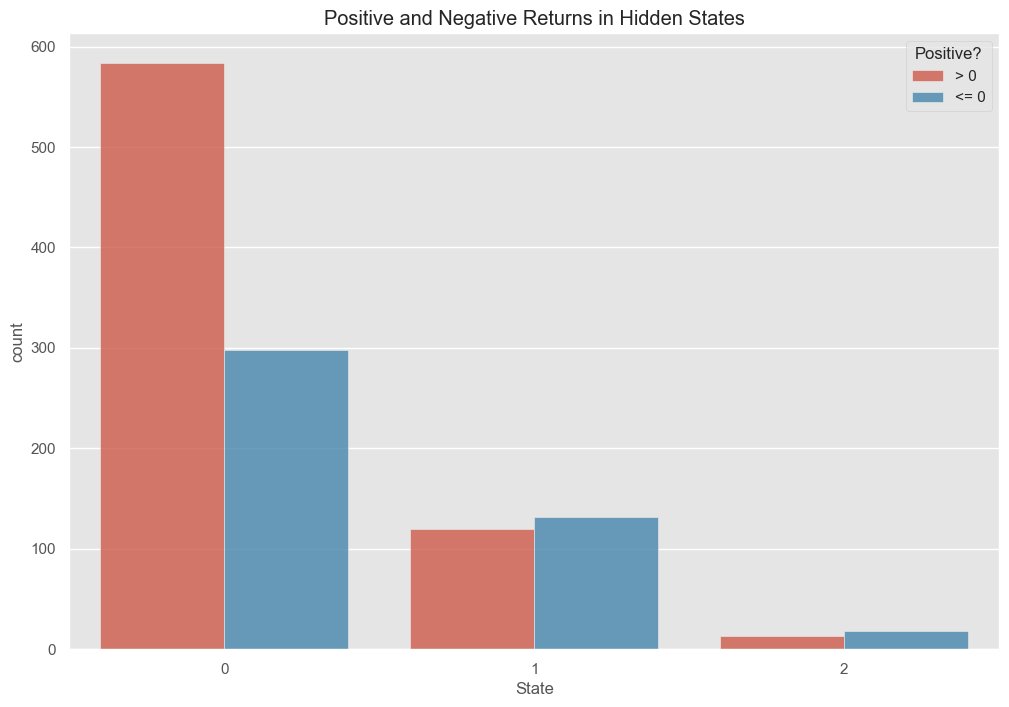

In [10]:
hmm_model.display_countplot_positive_negative_hidden_states()

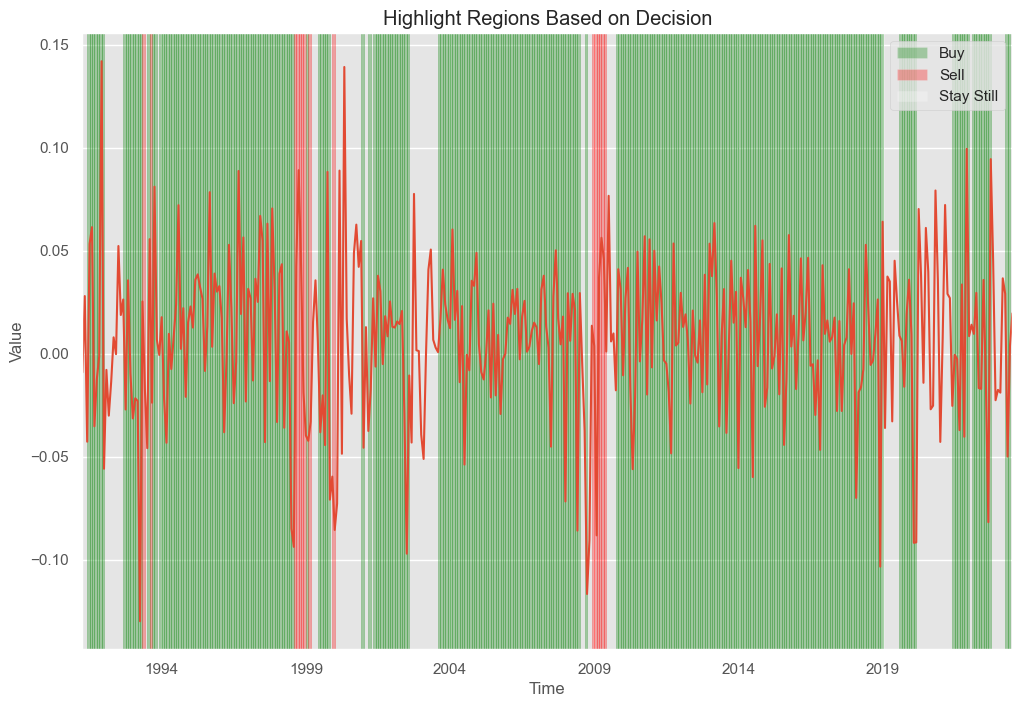

In [29]:
hmm_model.all_past_CV(train_size=2/3, omega=0.6, mu=0.5, plot=True, decision_metrics='simple')

388
388
Buy and Hold: 2.8572047453744385
 Strategy HMM: 2.481605473155502


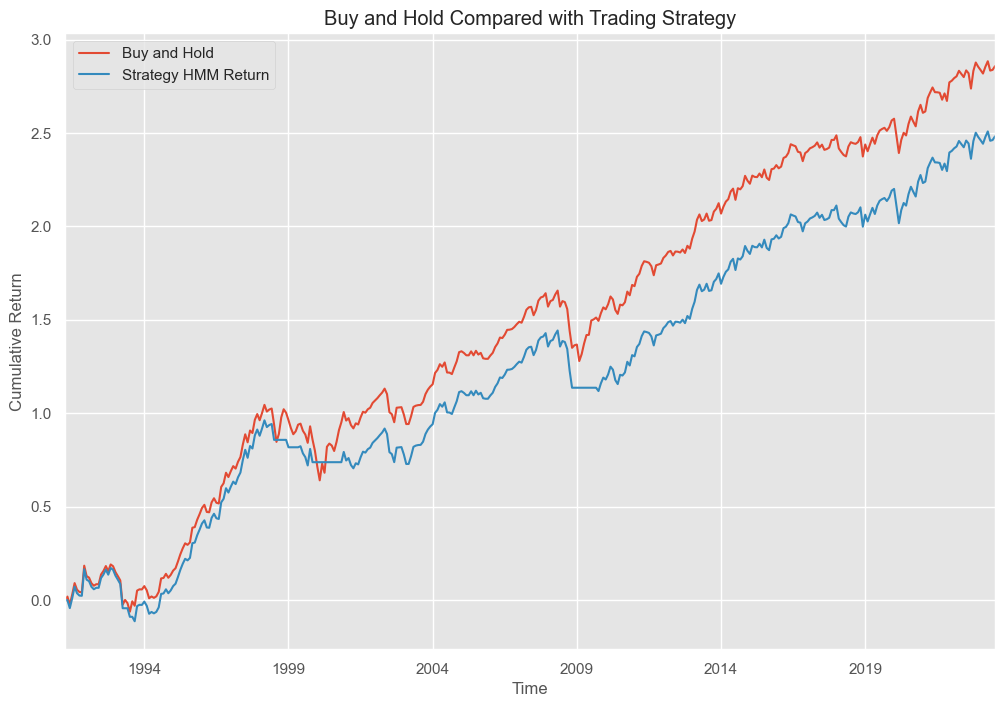

In [12]:
hmm_model.trading_strategy_ret(plot=True)

Model is not converging.  Current: 327.5811899871269 is not greater than 327.58235818060103. Delta is -0.0011681934741432087
Model is not converging.  Current: 337.34344745854673 is not greater than 337.3455322213243. Delta is -0.002084762777542437
Model is not converging.  Current: 344.74771753541177 is not greater than 344.7518305908138. Delta is -0.004113055402058308
Model is not converging.  Current: 387.8481779217502 is not greater than 387.8602402477908. Delta is -0.012062326040563676
Model is not converging.  Current: 395.884268539691 is not greater than 395.8858646223887. Delta is -0.0015960826976879616
Model is not converging.  Current: 401.3411077408488 is not greater than 401.3473000006049. Delta is -0.006192259756062413
Model is not converging.  Current: 409.7265464566329 is not greater than 409.7272048430904. Delta is -0.0006583864575304688
Model is not converging.  Current: 413.64824185090146 is not greater than 413.6557022252588. Delta is -0.007460374357322053
Model is n

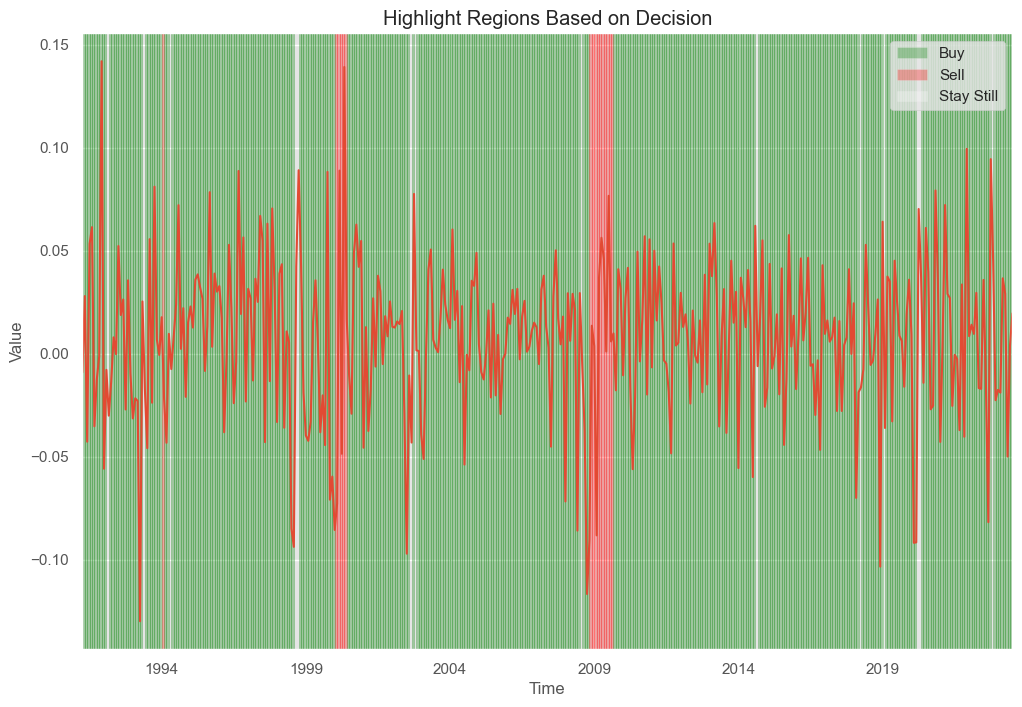

In [45]:
hmm_model.trailing_CV(train_size=2/3, trailing_window=200, omega=0.6, mu=0.5, plot=True, decision_metrics='simple')

388
388
Buy and Hold: 2.8572047453744385
 Strategy HMM: 2.656129772486436


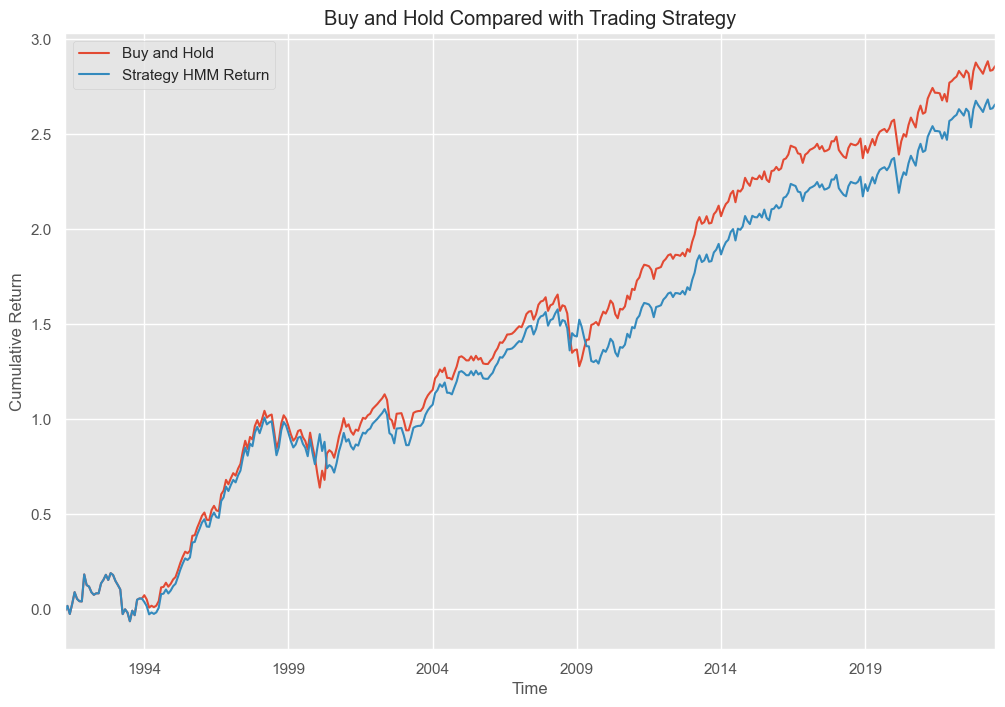

In [46]:
hmm_model.trading_strategy_ret(plot=True)

hmm_model.trailing_CV(train_size=2/3, trailing_window=200, omega=0.6, mu=0.5, plot=True, decision_metrics='weighted')

388
388
Buy and Hold: 2.8572047453744385
 Strategy HMM: 2.6601520833933523


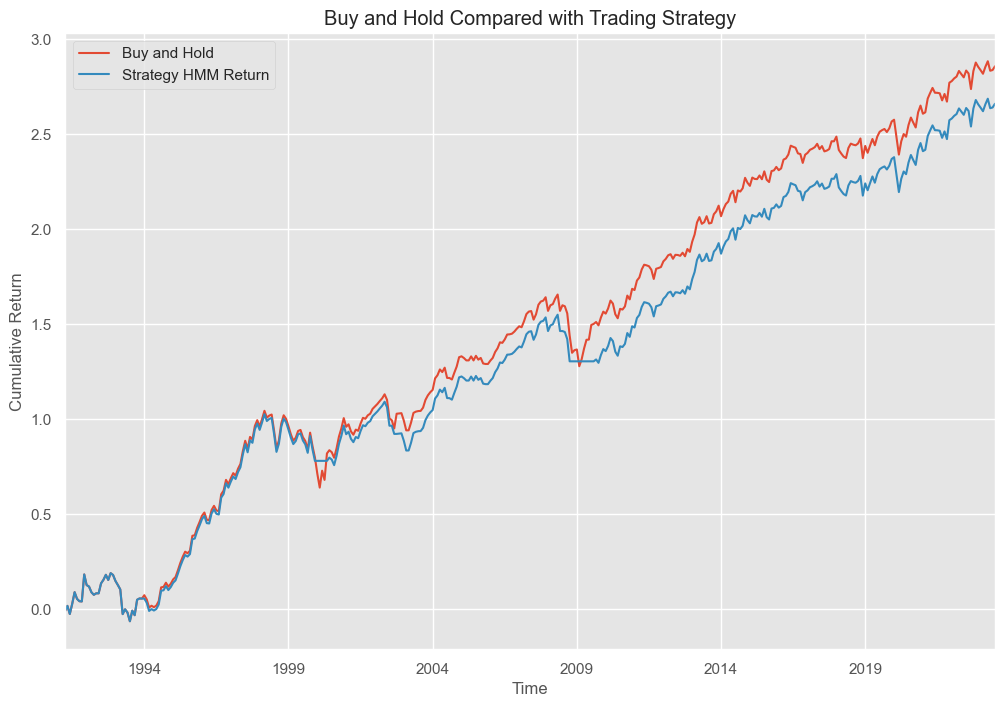

In [54]:
hmm_model.trading_strategy_ret(plot=True)

## Extract Values into CSV

In [58]:
def extract_data(train_size=2/3, window=120, omega=0.6, mu=0.5, metrics='simple'):
    data = kit.get_ind_30_ret()
    columns = data.columns
    index = data[int(data.shape[0]*train_size)+1:].index
    decisions = pd.DataFrame(columns=columns, index=index)
    views = pd.DataFrame(columns=columns, index=index)
    confidence = pd.DataFrame(columns=columns, index=index)
    for ind in columns:
        hmm_model = IndustryHMM(ind, f'{ind} Industry')
        hmm_model.model_selection()
        hmm_model.trailing_CV(train_size=train_size, trailing_window=window, omega=omega, mu=mu, decision_metrics=metrics)
        decisions.loc[:,ind] = hmm_model.get_decison_array()
        views.loc[:,ind] = hmm_model.get_absolute_view()
        confidence.loc[:,ind] = hmm_model.get_confidence_array()
    return decisions, views, confidence
    

In [59]:
decisions_simple, views_simple, confidence_simple = extract_data(train_size=2/3, window=200, omega=0.6, mu=0.5, metrics='simple')

Model is not converging.  Current: 327.5811899871269 is not greater than 327.58235818060103. Delta is -0.0011681934741432087
Model is not converging.  Current: 337.34344745854673 is not greater than 337.3455322213243. Delta is -0.002084762777542437
Model is not converging.  Current: 344.74771753541177 is not greater than 344.7518305908138. Delta is -0.004113055402058308
Model is not converging.  Current: 387.8481779217502 is not greater than 387.8602402477908. Delta is -0.012062326040563676
Model is not converging.  Current: 395.884268539691 is not greater than 395.8858646223887. Delta is -0.0015960826976879616
Model is not converging.  Current: 401.3411077408488 is not greater than 401.3473000006049. Delta is -0.006192259756062413
Model is not converging.  Current: 409.7265464566329 is not greater than 409.7272048430904. Delta is -0.0006583864575304688
Model is not converging.  Current: 413.64824185090146 is not greater than 413.6557022252588. Delta is -0.007460374357322053
Model is n

In [60]:
decisions_weighted, views_weighted, confidence_weighted = extract_data(train_size=2/3, window=200, omega=0.6, mu=0.5, metrics='weighted')

Model is not converging.  Current: 327.5811899871269 is not greater than 327.58235818060103. Delta is -0.0011681934741432087
Model is not converging.  Current: 337.34344745854673 is not greater than 337.3455322213243. Delta is -0.002084762777542437
Model is not converging.  Current: 344.74771753541177 is not greater than 344.7518305908138. Delta is -0.004113055402058308
Model is not converging.  Current: 387.8481779217502 is not greater than 387.8602402477908. Delta is -0.012062326040563676
Model is not converging.  Current: 395.884268539691 is not greater than 395.8858646223887. Delta is -0.0015960826976879616
Model is not converging.  Current: 401.3411077408488 is not greater than 401.3473000006049. Delta is -0.006192259756062413
Model is not converging.  Current: 409.7265464566329 is not greater than 409.7272048430904. Delta is -0.0006583864575304688
Model is not converging.  Current: 413.64824185090146 is not greater than 413.6557022252588. Delta is -0.007460374357322053
Model is n

In [62]:
# confidence_simple.to_csv('../Data/confidence_simple.csv')
# decisions_simple.to_csv('../Data/decisions_simple.csv')
# views_simple.to_csv('../Data/views_simple.csv')
# confidence_weighted.to_csv('../Data/confidence_weighted.csv')
# decisions_weighted.to_csv('../Data/decisions_weighted.csv')
# views_weighted.to_csv('../Data/views_weighted.csv')